In [1]:
#This is for Google Collab Notebook - it doesn't have torchplot installed!
!pip install torchplot
# Here we are importing the necessary libraries
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchplot as tplt
import numpy as np
import time
import os
import copy
import torch.optim as optim

from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, sampler, random_split

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We will be using the:", device)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchplot: filename=torchplot-0.2.0-py3-none-any.whl size=8327 sha256=652c2d874d04e30870245ce75a5f2f3185730c2ade61a737161afb8407b2f9b7
  Stored in directory: /root/.cache/pip/wheels/10/2c/51/20e41cb36ecf77321dfab07bc2119951e030e717222d78d742
Successfully built torchplot
PyTorch Version:  1.9.1
Torchvision Version:  0.10.1
We will be using the: cuda


In [2]:
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Our two datasets
emnist_dataset = datasets.EMNIST(root='./', split='letters', train=True, download=True, transform=transform)
# Load dataset
train_dataset = DataLoader(emnist_dataset,batch_size=10,)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


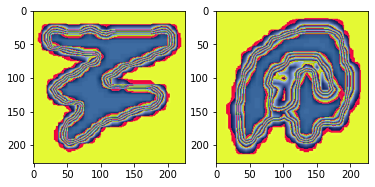

In [3]:
data = iter(train_dataset) # Let's iterate on it
single_point = next(data)
ToPIL = transforms.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [4]:
class LeNet(nn.Module):
    def __init__(self, nclasses=68):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6,5,padding=2)
        self.conv2 = nn.Conv2d(6,16,5, padding=0)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,nclasses)
        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = torch.sigmoid(self.conv2(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        x = x.view(-1, 5*5*16)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Code from https://medium.com/analytics-vidhya/alexnet-a-simple-implementation-using-pytorch-30c14e8b6db2
class AlexNet(nn.Module):
    def __init__(self, nclasses=68):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=nclasses)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Will append the test accuracy to the test_accuracy_history[]
def evaluate(model, test_data, test_accuracy_history, test_image_datasets_len):
    with torch.no_grad():
        test_accuracy = 0
        for (data, label) in test_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
            test_accuracy += (answers == label).sum()
    # Append the testing accuracy
    test_accuracy = test_accuracy / test_image_datasets_len * 100
    test_accuracy_history.append(test_accuracy)
    return test_accuracy
# Does not accept the test_accuracy_history[]
def evaluateAcc(model, test_data, test_data_len):
    with torch.no_grad():
        test_accuracy = 0
        for (data, label) in test_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
            test_accuracy += (answers == label).sum()
    # Append the testing accuracy
    test_accuracy = test_accuracy / test_data_len * 100
    return test_accuracy

In [7]:
def super_plotter(loss_history, test_accuracy_history, train_accuracy_history):
    # Plot the loss per iteration
    tplt.plot(loss_history, label="Loss")
    tplt.title("Neural Network Loss")
    tplt.xlabel("Number of iterations")
    tplt.ylabel("Loss History")
    tplt.legend(loc='upper right')
    tplt.show()
    # Plot the accuracy per epoch
    tplt.plot(test_accuracy_history, label="Test")
    tplt.plot(train_accuracy_history, label="Train")
    tplt.title("Neural Network Accuracy")
    tplt.xlabel("Epoch Number")
    tplt.ylabel("Accuracy")
    tplt.legend(loc='lower right')
    tplt.show()

In [8]:
def super_model_trainer(model, train_dataset, train_dataloader, test_dataset, test_dataloader, batch_size, optimizer, nepochs): 
    model.train()
    loss_history = []
    test_accuracy_history = []
    train_accuracy_history = []
    loss = torch.Tensor([0])
    for epoch in tqdm(range(nepochs), desc=f"Epoch", unit="epoch", disable=False):
        accuracy = 0
        for (data, label) in tqdm(train_dataloader, desc="iteration", unit="%", disable=True):
            # Here we clear the gradients
            optimizer.zero_grad(set_to_none=True)        
            # We need to make sure the tensors are on the same device as our model
            data = data.to(device)
            label = label.to(device)
            out = model(data)
        
            loss = LossFunction(out, label)
        
            loss.backward() # This function calculates all our gradients
            optimizer.step() # This function does our gradient descent with those gradients
            loss_history.append(loss.item())
            answers = out.max(dim=1)[1]
            accuracy += (answers == label).sum()
        # Append the training accuracy
        accuracy = accuracy / len(train_dataset)*100
        train_accuracy_history.append(accuracy)
    
        #let's get the test accuracy to see how well it generalizes
        test_accuracy = evaluate(model, test_dataloader, test_accuracy_history, len(test_dataset))
        #Print the results
        print(f"Epoch: {epoch} \n Loss: {loss.item()} \n Train Accuracy: {accuracy:.2f}% \n Test Accuracy: {test_accuracy:.2f}%")
    super_plotter(loss_history, test_accuracy_history, train_accuracy_history)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=37, bias=True)
)


Epoch:  20%|██        | 1/5 [06:22<25:30, 382.61s/epoch]

Epoch: 0 
 Loss: 0.2918081283569336 
 Train Accuracy: 84.41% 
 Test Accuracy: 92.66%


Epoch:  40%|████      | 2/5 [12:39<18:57, 379.19s/epoch]

Epoch: 1 
 Loss: 0.16404135525226593 
 Train Accuracy: 92.91% 
 Test Accuracy: 91.86%


Epoch:  60%|██████    | 3/5 [18:56<12:36, 378.16s/epoch]

Epoch: 2 
 Loss: 0.1106058657169342 
 Train Accuracy: 93.73% 
 Test Accuracy: 93.25%


Epoch:  80%|████████  | 4/5 [25:11<06:16, 376.80s/epoch]

Epoch: 3 
 Loss: 0.20481617748737335 
 Train Accuracy: 94.25% 
 Test Accuracy: 93.31%


Epoch: 100%|██████████| 5/5 [31:24<00:00, 376.98s/epoch]

Epoch: 4 
 Loss: 0.2922217547893524 
 Train Accuracy: 94.66% 
 Test Accuracy: 93.62%


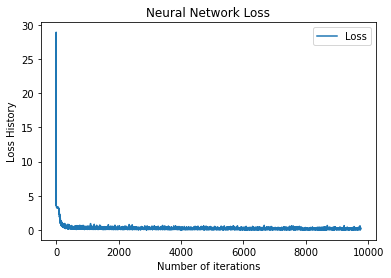

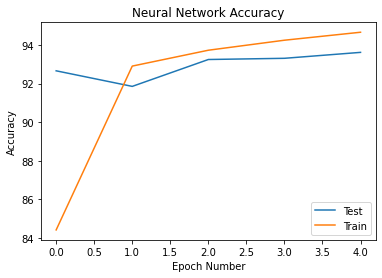

In [9]:
# Let's set up some parameters
learning_rate=0.001
nepochs = 5
nclasses=37
batch_size = 64


#model = LeNet(nclasses).to(device)

model = AlexNet(nclasses).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
LossFunction = nn.CrossEntropyLoss()

transformAlexNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transformLeNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor(),
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

transform = transformAlexNet

# Create the emnist train and test datasets
emnist_train_dataset = datasets.EMNIST(root='./', split='letters', train=True, download=True, transform=transform)
emnist_test_dataset = datasets.EMNIST(root='./', split='letters', train=False, download=False, transform=transform)


# Combine the train and test datasets and shuffle them together
train_dataset = emnist_train_dataset
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = emnist_test_dataset
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

#Training 
super_model_trainer(model, train_dataset, train_dataloader, test_dataset, test_dataloader, batch_size, optimizer, nepochs)

In [10]:
test_data_emnist = DataLoader(emnist_test_dataset,batch_size=batch_size,shuffle=True)
test_accuracy_emnist = evaluateAcc(model, test_data_emnist, len(emnist_test_dataset))

#Print the results
print(f"EMNIST Accuracy: {test_accuracy_emnist:.2f}%")

EMNIST Accuracy: 93.62%
